## **1. Import the necessary libraries**
---
- URL: https://youtu.be/IubEtS2JAiY
- REFERENCE: https://www.tensorflow.org/install/gpu

* Ensure that you have a Nvidia GPU
* Ensure that you have Tensorflow installed (pip install tensorflow) Using Tensorflow 2.3
* Download and install Nvidia GPU driver
* Please install Microsoft Visual Studio (Required to install CUDA Tool Kit)
* Download and install Nvidia GPU CUDA toolkit (Tensorflow currently only supports up to CUDA Toolkit 10.1)
* Download and install cuDNN (CuDNN 7.6 for CUDA Toolkit 10.1)


In [1]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import os, pathlib
import time

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.python.client import device_lib

model_folderpath = os.path.abspath(os.getcwd())
folderpath = pathlib.Path(model_folderpath).parent
data_folderpath = os.path.join(folderpath, 'Data')

print(folderpath)
print(model_folderpath)
print(data_folderpath)

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

print(tf.config.experimental.list_physical_devices(None))
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

C:\Users\onnwe\Desktop\ISS-PRSPM-GRP-18\ProjectModel
C:\Users\onnwe\Desktop\ISS-PRSPM-GRP-18\ProjectModel\Model
C:\Users\onnwe\Desktop\ISS-PRSPM-GRP-18\ProjectModel\Data
Versions of key libraries
---
tensorflow:  2.3.0
numpy:       1.18.5
matplotlib:  3.3.2
sklearn:     0.23.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]
Number of GPUs Available:  1


## **2. Create a function to plot image without axis**
---

In [2]:
def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

print(implt)

<function implt at 0x00000195C11E9A60>


## **3. Set matplotlib to have seaborn plot style**
---

In [3]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


## **4. Prepare image data for training and testing**
---
URL: https://www.tensorflow.org/tutorials/load_data/images

* Step 1: Set model parameters
* Setp 2: Create a dataset (with/without generator for data augumentation)
* Step 2: Print the class names
* Step 3: Retrieve the row size and the column size of each image

Found 5891 images belonging to 10 classes.
Found 1468 images belonging to 10 classes.
Class labels are {'Apple': 0, 'Avocado': 1, 'Banana': 2, 'BeanSprout': 3, 'Broccoli': 4, 'Chicken': 5, 'GreenBean': 6, 'Potato': 7, 'Salmon': 8, 'Tomato': 9}
The shape of Training Data Batch is  (32, 256, 256, 3)
The shape of Training Label Batch is  (32, 10)
The shape of Testing Data Batch is  (32, 256, 256, 3)
The shape of Testing Label Batch is  (32, 10)


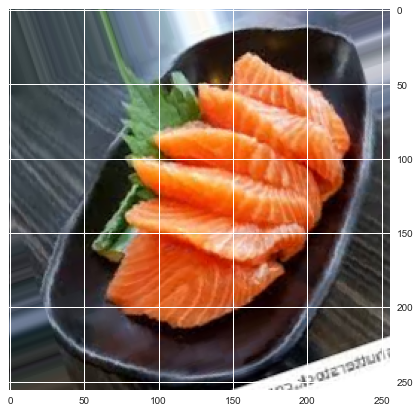

In [4]:
                                                                                # Step 1
batch_size = 32
img_height = 256
img_width = 256
seed = 42
validation_split = 0.2

                                                                                # Step 2
trDatagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=validation_split)

tsDatagen = ImageDataGenerator( 
    validation_split=validation_split)

trDatasetIter = trDatagen.flow_from_directory(
    data_folderpath,
    target_size=(img_height, img_width),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    subset='training')

tsDatasetIter = tsDatagen.flow_from_directory(
    data_folderpath,
    target_size=(img_height, img_width),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    subset='validation')

                                                                                # Step 3
class_names = trDatasetIter.class_indices
print(f"Class labels are {class_names}")

                                                                                # Step 4
image_batch, label_batch = trDatasetIter.next()
print(f"The shape of Training Data Batch is  {image_batch.shape}")
print(f"The shape of Training Label Batch is  {label_batch.shape}")
plt.imshow((image_batch[0]).astype(np.uint8))

    
image_batch, label_batch = tsDatasetIter.next()
print(f"The shape of Testing Data Batch is  {image_batch.shape}")
print(f"The shape of Testing Label Batch is  {label_batch.shape}")


## 5. Define the model
___
* Step 1: Setup the optimizer to be used for training
* Step 2: Set a name for the coming model (required for saving)
* Step 3: Define the number of classes
* Step 4: Define the convolutional neural network model (to be completed)
* Step 5: Create models for training and testing
* Step 6: Display the summary of the model of interest 

In [5]:
                                                                                # Step 1
learning_rate = 0.0005
optmz       = optimizers.RMSprop(lr=learning_rate)

                                                                                # Step 2
modelname   = 'Food_Classification_Gen10'

                                                                                # Step 3
num_classes = 10

                                                                                # Step 4
def createModel():
    
    xin = Input(shape=(256,256,3))
    x = Rescaling(1./255) (xin)
    
    x = Conv2D(64,(3,3),activation=None, padding='same')(x)
    x = Activation('relu') (x)

    x = MaxPooling2D(pool_size=(2,2)) (x)

    x = Conv2D(32,(3,3),activation=None, padding='same')(x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    
    x = MaxPooling2D(pool_size=(2,2)) (x)
    x = Conv2D(32,(3,3),activation=None, padding='same')(x)    
    x = Activation('relu') (x)

    x = MaxPooling2D(pool_size=(2,2)) (x)
    x = Conv2D(64,(3,3),activation=None, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization() (x)   
    x = Activation('relu') (x)
    
    x = MaxPooling2D(pool_size=(2,2)) (x)
    x = Conv2D(128,(3,3),activation=None, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization() (x)       
    x = Activation('relu') (x)

    x = MaxPooling2D(pool_size=(2,2)) (x)
    x = Flatten() (x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)) (x)
    x = Dropout(0.5) (x)
    x = Dense(num_classes, activation='softmax') (x)


    model = Model(inputs=xin,outputs=x)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optmz, 
                  metrics=['categorical_accuracy'])

    return model

                                                                                # Step 4
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()                                                                 # Step 5

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)     

## **6. Create the checkpoints to be applied during training**
---
* Step 1: Create a checkpoint to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a checkpoint to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two checkpoint objects into a list

In [6]:
                                                                                # Step 1
modelpath       = os.path.join(model_folderpath, modelname+'.hdf5')
logpath         = os.path.join(model_folderpath, modelname+'.csv')
checkpoint      = ModelCheckpoint(modelpath, 
                                  monitor='val_categorical_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                                                                                # Step 2
csv_logger      = CSVLogger(logpath)

                                                                                # Step 3
def lrSchedule(epoch):
    lr = learning_rate
    if epoch >= 55:
        lr *= 0.005
    elif epoch >= 45:
        lr *= 0.01
    elif epoch >= 35:
        lr *= 0.1
    elif epoch >= 20:
        lr *= 0.5

    print(f"Learning rate: {lr}")
    return lr 

LRScheduler = LearningRateScheduler(lrSchedule) 

                                                                               # Step 4
callbacks_list  = [checkpoint, csv_logger, LRScheduler]

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print(callbacks_list[2])
print('')
print("Path to model:", modelpath)
print("Path to log:  ", logpath)

Callbacks created:

Path to model: C:\Users\onnwe\Desktop\ISS-PRSPM-GRP-18\ProjectModel\Model\Food_Classification_Gen10.hdf5
Path to log:   C:\Users\onnwe\Desktop\ISS-PRSPM-GRP-18\ProjectModel\Model\Food_Classification_Gen10.csv


## **7. Train the deep learning model**
___
URL: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [7]:
start_time = time.time()

model.fit(trDatasetIter,                        # Training dataset
          validation_data=tsDatasetIter,        # Validation data and label
          epochs=60,                           # The amount of epochs to be trained                  
          shuffle=True,                         # To shuffle the training data
          callbacks=callbacks_list)             # Callbacks to execute the checkpoints

end_time = time.time()

print(f"Time taken: {(end_time - start_time)/60} mins")

Learning rate: 0.0005
Epoch 1/60
185/185 [==============================] - 84s 452ms/step - loss: 2.6725 - categorical_accuracy: 0.3745 - val_loss: 2.3277 - val_categorical_accuracy: 0.3685
Learning rate: 0.0005
Epoch 2/60
185/185 [==============================] - 83s 449ms/step - loss: 1.7373 - categorical_accuracy: 0.5249 - val_loss: 1.4413 - val_categorical_accuracy: 0.6151
Learning rate: 0.0005
Epoch 3/60
185/185 [==============================] - 83s 450ms/step - loss: 1.4771 - categorical_accuracy: 0.6176 - val_loss: 1.2835 - val_categorical_accuracy: 0.6805
Learning rate: 0.0005
Epoch 4/60
185/185 [==============================] - 83s 451ms/step - loss: 1.3059 - categorical_accuracy: 0.6685 - val_loss: 1.8364 - val_categorical_accuracy: 0.5170
Learning rate: 0.0005
Epoch 5/60
185/185 [==============================] - 83s 451ms/step - loss: 1.1879 - categorical_accuracy: 0.7068 - val_loss: 3.3487 - val_categorical_accuracy: 0.4319
Learning rate: 0.0005
Epoch 6/60
185/185 [===

185/185 [==============================] - 83s 450ms/step - loss: 0.2640 - categorical_accuracy: 0.9472 - val_loss: 0.4954 - val_categorical_accuracy: 0.9033
Learning rate: 5e-05
Epoch 43/60
185/185 [==============================] - 83s 450ms/step - loss: 0.2546 - categorical_accuracy: 0.9509 - val_loss: 0.4491 - val_categorical_accuracy: 0.8985
Learning rate: 5e-05
Epoch 44/60
185/185 [==============================] - 83s 450ms/step - loss: 0.2591 - categorical_accuracy: 0.9487 - val_loss: 0.5424 - val_categorical_accuracy: 0.8842
Learning rate: 5e-05
Epoch 45/60
185/185 [==============================] - 83s 450ms/step - loss: 0.2490 - categorical_accuracy: 0.9501 - val_loss: 0.5251 - val_categorical_accuracy: 0.9026
Learning rate: 5e-06
Epoch 46/60
185/185 [==============================] - 83s 449ms/step - loss: 0.2486 - categorical_accuracy: 0.9535 - val_loss: 0.4657 - val_categorical_accuracy: 0.9060
Learning rate: 5e-06
Epoch 47/60
185/185 [==============================] - 83

## **8. Validate the deep learning model**
---
* Step 1: Set a list of image and labels for the test dataset 
* Step 2: Load the trained weights and compile the model
* Step 3: Make prediction


(1468, 256, 256, 3)
(1468, 10)
1468
1468
{'Apple': 0, 'Avocado': 1, 'Banana': 2, 'BeanSprout': 3, 'Broccoli': 4, 'Chicken': 5, 'GreenBean': 6, 'Potato': 7, 'Salmon': 8, 'Tomato': 9}
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Prediction completes.


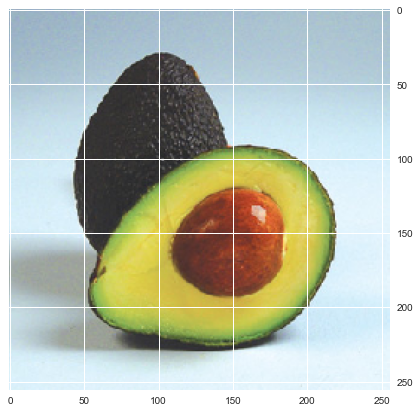

In [8]:
tsimages = []
tslabels = []
tsDatasetIter.reset()

for num_batches in range(tsDatasetIter.__len__()):
    image_batch, label_batch = tsDatasetIter.next()
    for i in range(len(label_batch)):
        tsimages.append(image_batch[i])
        tslabels.append(label_batch[i])

tsimages = np.array(tsimages)
        
print(np.shape(tsimages))
print(np.shape(tslabels))
print(len(tsimages))
print(len(tslabels))

plt.imshow(tsimages[0].astype(np.uint8))
print(class_names)
print(tslabels[0])

                                                                                # Step 2
modelGo.load_weights(modelpath)
modelGo.compile(loss='categorical_crossentropy',
                optimizer=optmz,
                metrics=['categorical_accuracy'])

                                                                                # Step 3
predicts    = modelGo.predict(tsimages)
print("Prediction completes.")

## **9. Report classification metrics**
---
* Step 1: Convert label from one-hot to integer
* Step 2: Obtain the class labels from the test dataset
* Step 3: Calculate the accuracy score
* Step 4: Generate classification report

In [9]:
                                                                                # Step 1
predout     = np.argmax(predicts,axis=1)

                                                                                # Step 2
testout     = np.argmax(tslabels, axis=1)

                                                                                # Step 3
testScores  = metrics.accuracy_score(testout, predout)                           

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

Best accuracy (on testing dataset): 90.94%
              precision    recall  f1-score   support

       Apple     0.9471    0.9624    0.9547       186
     Avocado     0.9748    0.6858    0.8052       226
      Banana     0.9767    0.9618    0.9692       131
  BeanSprout     0.8958    0.8431    0.8687        51
    Broccoli     0.9447    1.0000    0.9716       205
     Chicken     0.9476    0.9567    0.9522       208
   GreenBean     0.9912    0.9417    0.9658       120
      Potato     0.3840    0.8727    0.5333        55
      Salmon     0.9697    0.9458    0.9576       203
      Tomato     0.9494    0.9036    0.9259        83

    accuracy                         0.9094      1468
   macro avg     0.8981    0.9074    0.8904      1468
weighted avg     0.9377    0.9094    0.9159      1468



## **10. Print confusion matrix**
---

In [10]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[179   0   1   0   0   1   0   1   2   2]
 [  2 155   1   2   6   0   1  59   0   0]
 [  2   0 126   0   0   0   0   3   0   0]
 [  0   0   1  43   1   2   0   4   0   0]
 [  0   0   0   0 205   0   0   0   0   0]
 [  0   0   0   2   1 199   0   5   1   0]
 [  3   1   0   0   3   0 113   0   0   0]
 [  1   2   0   1   0   2   0  48   0   1]
 [  0   1   0   0   0   6   0   3 192   1]
 [  2   0   0   0   1   0   0   2   3  75]]


## **11. Plot curves on validation loss and accuracy**
---

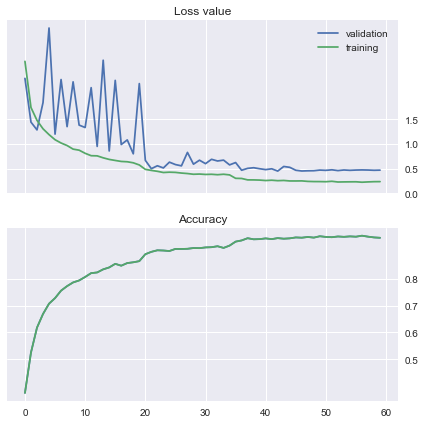

In [11]:
records     = pd.read_csv(logpath)
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['categorical_accuracy'],label="validation")
plt.plot(records['categorical_accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

## **12. Save the model plot**
---

In [12]:
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz 2.44.1\bin'

plotpath  = os.path.join(model_folderpath, modelname+'_plot.png')
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Path to plot: C:\Users\onnwe\Desktop\ISS-PRSPM-GRP-18\ProjectModel\Model\Food_Classification_Gen10_plot.png
